# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Зададим директорию с фото
PATH = '/datasets/faces/final_files/'
# Прочитаем датасет
labels = pd.read_csv(PATH+'../labels.csv')

In [3]:
# Посмотрим на размер выборки и на датасет
display(labels.info())
display(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Всегод 7591 фото, пропусков и аномалий нет.

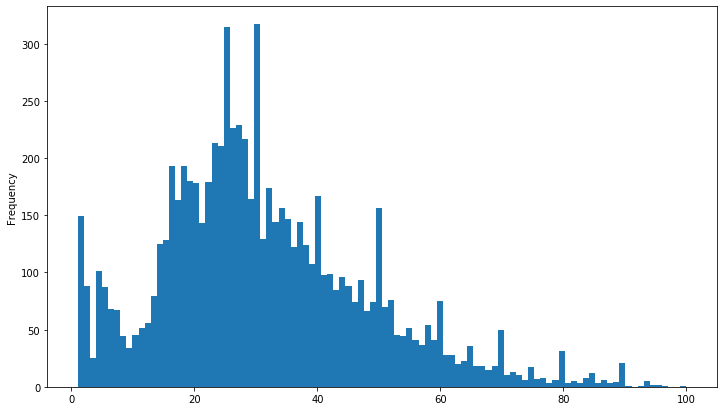

In [4]:
# Построим график распределения возраста в выборке
labels.real_age.plot.hist(bins=100,figsize=(12, 7));

На гистограмме видны выбросы на круглых датах. Вероятно это связано с тем, что люди склонны приуменьшать свой возраст и округляют его в меньшую сторону. Данные артефакты могут ухудшить обучаемость и точность модели.

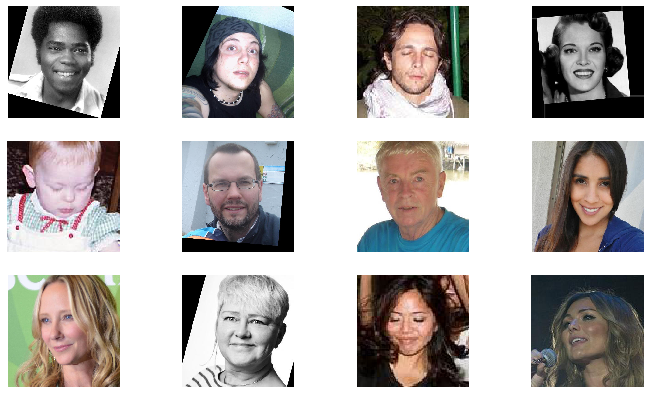

In [5]:
# Выведем на экране 12 случайных фотографий.
plt.figure(figsize=(12, 7))
for i in range(1,13):
    ax = plt.subplot(3, 4, i)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.axis('off')
    
    image = Image.open(PATH+labels.file_name[np.random.randint(0,len(labels))])
    array = np.array(image)

    plt.imshow(array);

# 2. Обучение модели

**Код обучения модели:**

```python
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(PATH):
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1/255.0)
    
    labels = pd.read_csv(PATH+'labels.csv')

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=PATH+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow

def load_test(PATH):
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1/255.0)
    
    labels = pd.read_csv(PATH+'labels.csv')
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=PATH+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

**результат вывода:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 49s - loss: 199.9914 - mae: 10.2039 - val_loss: 749.1821 - val_mae: 22.4242
Epoch 2/10
178/178 - 40s - loss: 65.2624 - mae: 6.1140 - val_loss: 357.3448 - val_mae: 13.9384
Epoch 3/10
178/178 - 40s - loss: 33.6462 - mae: 4.4583 - val_loss: 255.6412 - val_mae: 11.7885
Epoch 4/10
178/178 - 40s - loss: 22.3733 - mae: 3.6591 - val_loss: 120.2000 - val_mae: 8.5563
Epoch 5/10
178/178 - 40s - loss: 17.7514 - mae: 3.2504 - val_loss: 89.8900 - val_mae: 7.3790
Epoch 6/10
178/178 - 40s - loss: 14.0348 - mae: 2.8685 - val_loss: 74.0918 - val_mae: 6.6676
Epoch 7/10
178/178 - 40s - loss: 11.2673 - mae: 2.5470 - val_loss: 70.2752 - val_mae: 6.3703
Epoch 8/10
178/178 - 41s - loss: 9.7024 - mae: 2.3608 - val_loss: 67.5099 - val_mae: 6.1402
Epoch 9/10
178/178 - 40s - loss: 8.0589 - mae: 2.1556 - val_loss: 64.7387 - val_mae: 6.0215
Epoch 10/10
178/178 - 40s - loss: 7.3203 - mae: 2.0533 - val_loss: 71.5940 - val_mae: 6.3960

Test MAE: 6.3960


```

# 3. Анализ обученной модели

В тренировочную выборку попало 5694 фотографии и тестовую выборку 1897 фото. Или 178 и 60 батчей по 32 фото соответственно. Каждая эпоха обучения длилась примерно 40 секунд, соответственно общее время обучения длилось меньше 7 минут.

По результатам вывода видно, что уже на пятой эпохе MAE тестовой выборки составило меньше 8, что соответствует требованиям проекта. После 7ой эпохи MAE тренировочной и тестовой выборки пратически перестало уменьшаться, что говорит о бессмысленности дальнейшего обучения и увеличения кол-ва эпох.

# Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы